# 仅用batch1训练，在batch1-10上测试性能

In [3]:
import sys
import os

# 1. 自动定位项目根目录 (TinyML_Gas_Drift)
# 假设 Notebook 在 notebooks/ 文件夹下，'..' 就是根目录
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 2. 强制定位你的 conda 环境 site-packages (解决 DLL 报错)
# 请确保这个路径指向你安装了 CPU 版 torch 的环境
conda_env_path = r'C:\Users\yzhou\AppData\Local\anaconda3\envs\tinyml_drift\Lib\site-packages'
if conda_env_path not in sys.path:
    sys.path.insert(0, conda_env_path)

# 3. 解决 Windows 下的 DLL 冲突 (针对 WinError 1114)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
env_dll_path = r'C:\Users\yzhou\AppData\Local\anaconda3\envs\tinyml_drift\Library\bin'
if os.path.exists(env_dll_path):
    os.add_dll_directory(env_dll_path)

# 4. 现在尝试导入
try:
    import torch
    from src.data_loader import GasSensorLoader
    from src.models import GasSensorMLP
    print("✅ 环境校准成功！PyTorch 和项目模块均已加载。")
    print(f"当前 Python 解释器: {sys.executable}")
except Exception as e:
    print(f"❌ 依然存在问题: {e}")

✅ 环境校准成功！PyTorch 和项目模块均已加载。
当前 Python 解释器: C:\Users\yzhou\AppData\Local\anaconda3\envs\tinyml_drift\python.exe


正在 Batch 1 上训练 Baseline 模型...

开始评估全生命周期准确率...
Batch  1 | 准确率:  99.55%
Batch  2 | 准确率:  88.91%
Batch  3 | 准确率:  75.54%
Batch  4 | 准确率:  59.01%
Batch  5 | 准确率:  43.65%
Batch  6 | 准确率:  44.30%
Batch  7 | 准确率:  40.88%
Batch  8 | 准确率:  19.73%
Batch  9 | 准确率:  34.26%
Batch 10 | 准确率:  43.39%


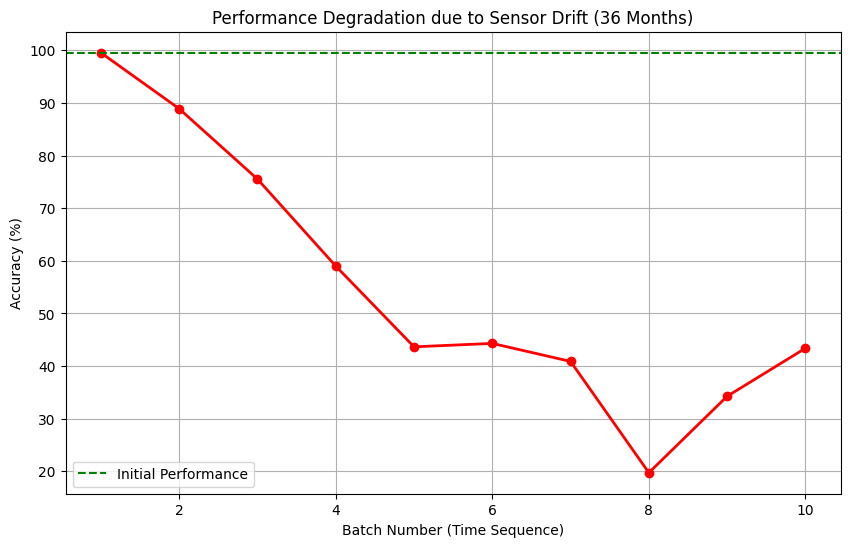

In [4]:
import torch
import torch.nn as nn          # 修复 'nn' is not defined
import torch.optim as optim    # 同时预防下一个可能的 'optim' 报错
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from src.data_loader import GasSensorLoader
from src.models import GasSensorMLP
import matplotlib.pyplot as plt
import numpy as np

# 1. 准备数据 (仅用 Batch 1)
loader = GasSensorLoader(data_dir='../Dataset')
X1, y1 = loader.load_batch(1)

# 标准化 (非常关键，记录下 scaler 以备后用)
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# 转为 PyTorch 张量
X_train = torch.FloatTensor(X1_scaled)
y_train = torch.LongTensor(y1)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 训练模型
model = GasSensorMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("正在 Batch 1 上训练 Baseline 模型...")
for epoch in range(50):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# 3. 跨批次评估性能 (Batch 1 到 10)
accuracies = []
print("\n开始评估全生命周期准确率...")

for i in range(1, 11):
    Xi, yi = loader.load_batch(i)
    # 使用 Batch 1 的 scaler 进行转换 (模拟模型出厂后的状态)
    Xi_scaled = scaler.transform(Xi)
    
    X_test = torch.FloatTensor(Xi_scaled)
    y_test = torch.LongTensor(yi)
    
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        acc = 100 * correct / len(y_test)
        accuracies.append(acc)
        print(f"Batch {i:2d} | 准确率: {acc:6.2f}%")

# 4. 绘制性能退化曲线 (核心交付物)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o', linestyle='-', color='r', linewidth=2)
plt.axhline(y=accuracies[0], color='g', linestyle='--', label='Initial Performance')
plt.title("Performance Degradation due to Sensor Drift (36 Months)")
plt.xlabel("Batch Number (Time Sequence)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

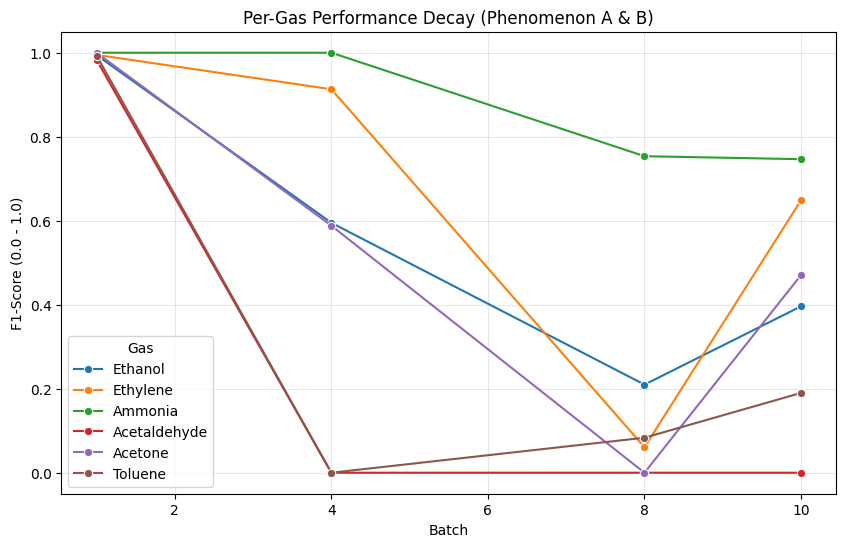

In [9]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import torch

# ---------------------------------------------------------
# 修复 A: 定义 datasets 字典，让函数能找到你的 scaler
# ---------------------------------------------------------
datasets = {'scaler': scaler} 

def analyze_class_decay(model, loader, datasets):
    results = []
    # 类别映射 (UCI 原始标签 1-6)
    target_names = ['Ethanol', 'Ethylene', 'Ammonia', 'Acetaldehyde', 'Acetone', 'Toluene']
    
    # 评估几个关键时间点 (Day 5 任务)
    test_batches = [1, 4, 8, 10] 
    
    model.eval() # 切换到评估模式
    scaler = datasets['scaler']
    
    for bid in test_batches:
        # 加载并标准化
        X_raw, y_raw = loader.load_batch(bid)
        X_norm = scaler.transform(X_raw)
        
        # 修复 B: 适配 PyTorch 推理逻辑 (代替 model.predict)
        X_tensor = torch.FloatTensor(X_norm)
        with torch.no_grad():
            outputs = model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            y_pred = predicted.numpy()
        
        # 获取各类别 F1-Score
        # 注意：UCI 标签 1-6 需要对应模型输出 0-5，因此 classification_report 需指定 labels
        report = classification_report(y_raw, y_pred, 
                                       target_names=target_names, 
                                       labels=range(6),
                                       output_dict=True,
                                       zero_division=0)
        
        for label in target_names:
            results.append({
                'Batch': bid,
                'Gas': label,
                'F1-Score': report[label]['f1-score']
            })

    # 2. 绘图
    df_res = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_res, x='Batch', y='F1-Score', hue='Gas', marker='o')
    plt.title("Per-Gas Performance Decay (Phenomenon A & B)")
    plt.ylabel("F1-Score (0.0 - 1.0)")
    plt.grid(True, alpha=0.3)
    plt.show()

# 执行分析
analyze_class_decay(model, loader, datasets)

模型推理：model(X_tensor) 输出每个样本属于 6 类气体的概率。硬分类：通过 torch.max(outputs, 1) 取得概率最大的索引（0-5），作为预测结果 y_pred。矩阵统计：classification_report 内部会根据 y_raw（真实值）和 y_pred（预测值）构建一个 6x6 的混淆矩阵。数值提取：它会针对每个 target_names（如 'Ethanol'）分别计算其对应的 $TP$、$FP$、$FN$。最后通过上述公式计算出每个气体的 F1-Score 并存入 results 列表进行绘图。

# drift

In [13]:
import numpy as np
import torch

class GasDriftSimulator:
    def __init__(self, num_sensors=16, features_per_sensor=8):
        self.num_sensors = num_sensors
        self.fps = features_per_sensor
        self.total_dim = num_sensors * features_per_sensor

    def apply_gain_drift(self, X, scale_range=(0.8, 1.2), mode='random'):
        """
        模拟增益漂移 (Gain Drift)：x = x * (1 + alpha)
        mode='global': 所有传感器同步缩放 (模拟电路级故障)
        mode='sensor': 每个传感器独立缩放 (模拟传感器个体老化)
        """
        X_drifted = X.copy()
        num_samples = X.shape[0]

        if mode == 'global':
            # 模拟你在 Batch 2 看到的那种整体增益波动
            scales = np.random.uniform(scale_range[0], scale_range[1], size=(num_samples, 1))
            X_drifted *= scales
            
        elif mode == 'sensor':
            # 更加硬核：模拟 16 个传感器中不同的老化速度
            for i in range(self.num_sensors):
                # 针对第 i 个传感器的 8 个特征施加相同的缩放因子
                s_idx = i * self.fps
                e_idx = (i + 1) * self.fps
                sensor_scales = np.random.uniform(scale_range[0], scale_range[1], size=(num_samples, 1))
                X_drifted[:, s_idx:e_idx] *= sensor_scales
                
        return X_drifted

    def apply_offset_drift(self, X, offset_intensity=0.1):
        """
        模拟基准漂移 (Baseline/Offset Drift)：x = x + beta
        beta 基于每个维度的标准差进行缩放
        """
        noise = np.random.normal(0, offset_intensity, size=X.shape)
        return X + noise

# 实例化模拟器
simulator = GasDriftSimulator()

In [15]:
# 1. 准备人工漂移数据
# 模拟 Batch 2 的极端情况：16 个传感器中有一半发生了 3 倍增益偏移
X1_raw, y1 = loader.load_batch(1)
X1_drifted = simulator.apply_gain_drift(X1_raw, scale_range=(2.5, 3.5), mode='sensor')

# 2. 标准化与推理
# 注意：必须使用 Batch 1 的 scaler，这才是“出厂状态”
X1_drifted_norm = datasets['scaler'].transform(X1_drifted)
X_tensor = torch.FloatTensor(X1_drifted_norm)

with torch.no_grad():
    model.eval()
    outputs = model(X_tensor)
    _, predicted = torch.max(outputs, 1)
    acc_drifted = 100 * (predicted.numpy() == y1).sum() / len(y1)

print(f"📉 人工 3 倍增益漂移后的准确率: {acc_drifted:.2f}%")

📉 人工 3 倍增益漂移后的准确率: 85.84%


Text(0, 0.5, 'Accuracy (%)')

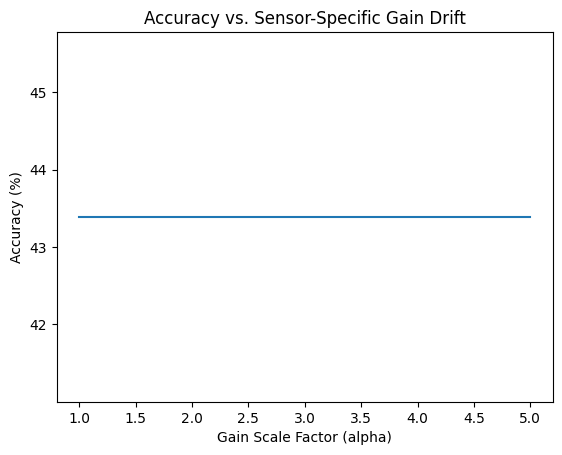

In [17]:
alphas = np.linspace(1.0, 5.0, 20)
results = []

for a in alphas:
    X_test_drift = simulator.apply_gain_drift(X1_raw, scale_range=(a, a), mode='sensor')
    # ... 进行推理并计算 acc ...
    results.append(acc)

plt.plot(alphas, results)
plt.title("Accuracy vs. Sensor-Specific Gain Drift")
plt.xlabel("Gain Scale Factor (alpha)")
plt.ylabel("Accuracy (%)")

In [23]:
def apply_relative_drift(X, scale=3.0, beta=0.5):
    """
    按比例引入偏移，确保漂移具有破坏性
    beta=0.5 意味着将信号中心平移 0.5 个标准差
    """
    # 1. 获取训练集的标准差 (从你的 scaler 中提取)
    # 如果你用的是 StandardScaler: scaler.scale_
    # 如果你用的是 RobustScaler: scaler.scale_ (代表分位数间距)
    stds = datasets['scaler'].scale_
    
    # 2. 施加增益漂移
    X_drifted = simulator.apply_gain_drift(X, scale_range=(scale, scale), mode='sensor')
    
    # 3. 施加相对偏移：为每一维生成独立的 beta * std 偏移
    # 模拟 16 个传感器中每个通道不同的电平漂移
    relative_offsets = np.random.uniform(-beta, beta, size=(1, X.shape[1])) * stds
    X_drifted = X_drifted + relative_offsets
    
    return X_drifted
# 尝试更真实的模拟：3倍增益 + 0.8倍标准差偏移
X_broken = apply_relative_drift(X1_raw, scale=3.0, beta=0.8)

X_broken_norm = datasets['scaler'].transform(X_broken)
X_tensor = torch.FloatTensor(X_broken_norm)

model.eval()
with torch.no_grad():
    outputs = model(X_tensor)
    _, predicted = torch.max(outputs, 1)
    acc_broken = 100 * (predicted.numpy() == y1).sum() / len(y1)

print(f"📉 相对偏移漂移后的准确率: {acc_broken:.2f}%")

📉 相对偏移漂移后的准确率: 87.19%


In [33]:
def apply_asymmetric_drift(X, scale=3.0, beta=1.0, chaos=0.5):
    """
    引入非对称破坏：模拟不同传感器向不同方向漂移
    chaos: 混乱强度 (0.0 - 1.0)
    """
    stds = datasets['scaler'].scale_
    X_drifted = X.copy()
    
    # 对 16 个传感器进行循环
    for i in range(16):
        s_idx, e_idx = i * 8, (i + 1) * 8
        
        # 为每个传感器随机决定一个独立的增益系数 alpha_i 和 偏移系数 beta_i
        # 模拟 16 个硬件单元完全不同的老化轨迹
        alpha_i = np.random.uniform(1.0, scale) if np.random.rand() < chaos else 1.0
        beta_i = np.random.uniform(-beta, beta) if np.random.rand() < chaos else 0.0
        
        X_drifted[:, s_idx:e_idx] = alpha_i * X_drifted[:, s_idx:e_idx] + beta_i * stds[s_idx:e_idx]
        
    return X_drifted

# 尝试极限测试：3倍增益 + 1倍标准差偏移 + 0.8 混乱度
X_chaos = apply_asymmetric_drift(X1_raw, scale=3.0, beta=1.0, chaos=0.8)


# 1. 标准化 (模拟模型在出厂标定后的输入)
x_chaos_norm = datasets['scaler'].transform(X_chaos)

# 2. 转换为 Tensor 并推理
x_chaos_tensor = torch.FloatTensor(x_chaos_norm)
model.eval()
with torch.no_grad():
    outputs = model(x_chaos_tensor)
    _, y_pred_chaos = torch.max(outputs, 1)
    y_pred_chaos = y_pred_chaos.numpy()

# 3. 输出评估报告
acc_chaos = 100 * (y_pred_chaos == y1).sum() / len(y1)
print(f"🔥 [Chaos Test] 准确率: {acc_chaos:.2f}%")
print("\n[Chaos Analysis] 详细分类报告:")
print(classification_report(y1, y_pred_chaos, target_names=['Eth', 'Etl', 'Amm', 'Ace', 'Act', 'Tol']))

🔥 [Chaos Test] 准确率: 91.69%

[Chaos Analysis] 详细分类报告:
              precision    recall  f1-score   support

         Eth       0.97      0.99      0.98        90
         Etl       0.99      0.97      0.98        98
         Amm       1.00      1.00      1.00        83
         Ace       0.48      1.00      0.65        30
         Act       1.00      0.99      0.99        70
         Tol       1.00      0.57      0.72        74

    accuracy                           0.92       445
   macro avg       0.91      0.92      0.89       445
weighted avg       0.96      0.92      0.92       445

